# Fifth Exercise (Chapter 10)

This exercise focuses on recurrent neural networks (RNN). Also, we'll be using Pytorch from now on 🎉!

We will:
- implement an LSTM cell in Pytorch,
- train two forms of RNNs, namely:
    - many to one: value memorization
    - many to many: de-noising sequences

In [1]:
from typing import Tuple, Union

import numpy as np  # generate training data
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Preliminary Questions

Before we dive into the implementation parts, let's think about a few aspects of recurrent neural networks.
*Hint: Reading chapter 10 of the deep learning book might help with answering the questions.* Two other great resources are:
- Andrej Karpathy's [blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), which, among other things, nicely explains the different variants of RNNs (one-to-one, many-to-many, etc).
- Chris Olah's [blog post on LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).



**1.** In what sense are convolutional neural networks and recurrent neural networks similar? In what sense are they different?

**Answer**: 
Both architectures have an input, hidden and output layer and use weight sharing. <br>
CNN have fixed convolutional windows and a fixed number of layers and are therefore more restricted than RNN. Moreover CNN's working in a hierarchical fashion. (convolution, pooling etc.). <br>
In contrast RNN's could operate over sequences in the input and store information. (e.g Machine Translation) 


**2.** How can one counteract vanishing or exploding gradients in RNNs, allowing to learn long-term dependencies?

**Answer**: For exploding gradients one could use gradient clipping. It restricts the magnitude of the gradient. <br>
For vanishing gradients we use LSTM's. The gating allows us to decide how much the gradient vanishes.


### Feedback 

This theoretical part was a nice warm up to get into the task. Additionally the blog post on LSTMs contains very nice explanations and visualisations of LSTMs. We needed 1 hour for preparing the questions.

## LSTM cell
See chapter 10.10.1 of the DL book.

In Pytorch, all layers inherit from `nn.Module` and implement the `forward` function (the `backward` pass is computed automatically). Parameters should be initialized in the constructor.

To get a feeling for how layers are implemented in pytorch, you can for example take a look at the source code of the [Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) ($h = wX+b$).

Your task here is to implement the LSTMCell, which takes a feature tensor and the hidden state as input and returns the new hidden state (sometimes also referred to as output) and the new cell state.


In [2]:
class LSTMCell(nn.Module):
    """The LSTM layer."""
    
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # START TODO #############
        
        
        # uniform ditr. between -0.01 & 0.01
        lb = -0.01
        hg = 0.01
        self.weight_ingate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_forgetgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_cellgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size) + hg))
        self.weight_outgate = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.input_size + self.hidden_size, self.hidden_size)+ hg))

        self.bias_ig = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_fg = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_cg = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))
        self.bias_og = torch.nn.Parameter(torch.Tensor((lb - hg) * torch.rand(self.hidden_size)+ hg))

        # initialize required parameters / layers
        # END TODO #############
        
    def forward(self, x: torch.Tensor, hx: Tuple[torch.Tensor] = None) -> Tuple[torch.Tensor]:
        """
        
        Args:
            x: The input tensor with shape (batch_size, feature_dim)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size).
                
        Returns:
            Tuple as (output_hidden, new_internal_state).
        """
        if hx is None:
            hx = self._init_hidden_state(x)
        hidden_state, internal_state = hx
        
        # START TODO #############
        con = torch.cat((hidden_state, x),1)

        ingate = torch.sigmoid(torch.mm(con, self.weight_ingate) + self.bias_ig)
        forgetgate = torch.sigmoid(torch.mm(con,self.weight_forgetgate) + self.bias_fg)
        cellgate = torch.tanh(torch.mm(con,self.weight_cellgate) + self.bias_cg)
        outgate = torch.sigmoid(torch.mm(con,self.weight_outgate) + self.bias_og)

        new_internal_state = (forgetgate * internal_state) + (ingate * cellgate)
        output_hidden = outgate * torch.tanh(new_internal_state)

        # END TODO #############
        
        return output_hidden, new_internal_state
        
    def _init_hidden_state(self, x):
        """Returns the hidden state with zeros.
        
        Returns:
            A two-tuple (initial_hidden_state, initial_cell_state).
            Both are all zeros with shape (batch_size, hidden_size).
        """
        batch_size = x.shape[0]

        initial_hidden_state = torch.zeros(batch_size, self.hidden_size)
        initial_cell_state = torch.zeros(batch_size, self.hidden_size)

        # START TODO #############
        return (initial_hidden_state, initial_cell_state)
        # END TODO #############

In [3]:
class LSTM(LSTMCell):
    """Convenience class that automatically iterates over the sequence."""
    
    def forward(self, x: Union[np.ndarray, torch.Tensor], hx=None):
        """Iterate over the sequence and apply the LSTM cell.
        
        Args:
            x: The input tensor with shape (seq_len, batch, input_size)
            hx: The initial hidden state, optional. Is a two-tuple consisting of
                the current hidden state and the internal cell state. Both have
                shape (batch_size, hidden_size). If None, set to zero.
        
        Returns:
            Tuple as (output_stacked_hidden, (last_hidden_state, last_new_internal_state)).
            output_stacked_hidden is the stacked output of all LSTMCells
            (excluding the cell state!)
        """
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x, requires_grad=True)

        # START TODO #############
        # iterate over the sequence and apply the LSTM
        output_stacked_hidden = torch.Tensor(x.shape[0], x.shape[1], self.hidden_size

        for seq in range(x.shape[0]):
            (hidden_state, cell_state) = super().forward(x[seq, :, :], hx)
            output_stacked_hidden[seq] = hidden_state
            
            hx = (hidden_state, cell_state)

        return (output_stacked_hidden, hx)

        # END TODO #############

As a simple test, let's see if the LSTM can learn to echo a value at a specific index of the sequence. If your implementation is correct, you should get around 97% accuracy.

In [4]:
# Create 100 training sequences of length 10
num_samples = 1000
seq_length = 10
batch_size = 5
# we use a hidden size larger 1 as it makes training easier
# as prediction we compute the mean over the output.
hidden_size = 6
training_sequences = torch.rand(seq_length, num_samples, 1)
test_sequences = torch.rand(seq_length, 100, 1)
model = LSTM(1, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def accuracy(y, label, eps=1e-2):
    assert y.shape == label.shape, (y.shape, label.shape)
    return np.sum(np.abs(y - label) < eps) / len(y)


for epoch in range(101):
    for batch_idx in range(num_samples // batch_size):
        optimizer.zero_grad()
        batch = training_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
        output = model(batch)[1][0]
        labels = batch[1]  # echo the second element
        loss = loss_fn(labels, output)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        print(f"epoch: {epoch}, loss:{loss}")
        output = model(test_sequences)[1][0]
        labels = test_sequences[1]  # echo the second element
        acc = accuracy(np.squeeze(labels.numpy()),
                       np.mean(output.detach().numpy(), axis=-1))
        print(f"test accuracy: {acc}")
    scheduler.step()
    

epoch: 0, loss:4.4244771003723145
test accuracy: 0.01
epoch: 10, loss:0.2077615112066269
test accuracy: 0.13
epoch: 20, loss:0.022022001445293427
test accuracy: 0.41
epoch: 30, loss:0.009407434612512589
test accuracy: 0.38
epoch: 40, loss:0.004458901006728411
test accuracy: 0.73
epoch: 50, loss:0.008431687951087952
test accuracy: 0.36
epoch: 60, loss:0.0064393156208097935
test accuracy: 0.31
epoch: 70, loss:0.0012266093399375677
test accuracy: 0.82
epoch: 80, loss:0.0003854995593428612
test accuracy: 0.96
epoch: 90, loss:0.0002503624127712101
test accuracy: 0.99
epoch: 100, loss:0.00015774414350744337
test accuracy: 0.99


### Feedback 

This task was tricky. One needed to know that the range for the initializations of the uniform weights/bias is very important for the accuracy. Additionally the first wrong describtion of the return value from LSTM forward was confusing. We needed 8 hours for this task.

## LSTM Use Case - Noise Removal
Implement an RNN to remove noise from different sine function instances. If you didn't finish the `LSTM` implementation part, you can use `nn.LSTM` here.

The goal is to remove gaussian noise from a sequence generated from a sine function.

To get an idea what the data look like, plot six different sine function instances with and without noise.

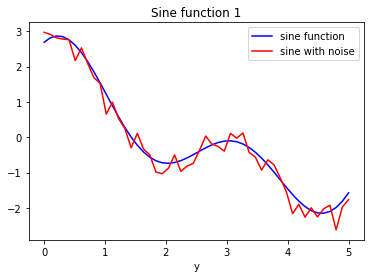

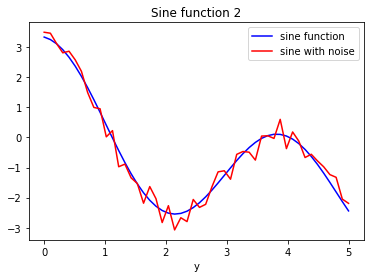

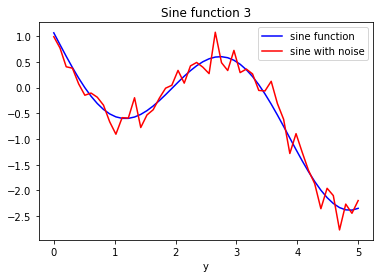

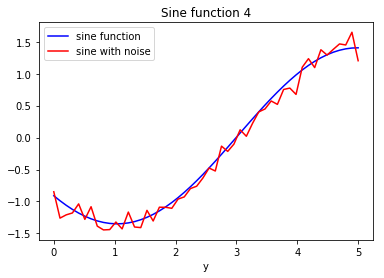

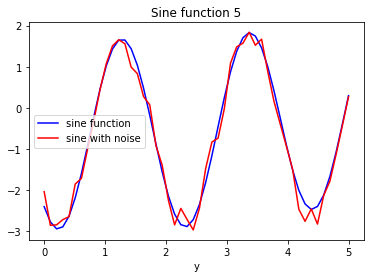

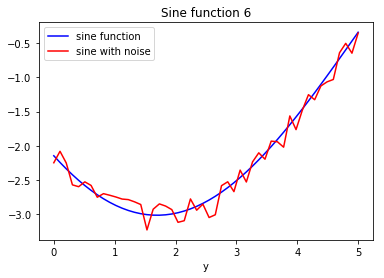

In [19]:
# let's create a generator for sine functions with different amplitudes, shift and frequency

class RandomSineFunction:
    
    def __init__(self):
        num_sines = np.random.randint(1, 4)
        self.amplitude = np.random.uniform(0, 2, num_sines)
        self.offsets = np.random.uniform(-np.pi, np.pi, num_sines)
        self.frequency = np.random.uniform(0.1, 1, num_sines)
        
    def __call__(self, x):
        return np.array([a * np.sin(np.pi * f * x + o)
                         for a, f, o in zip(self.amplitude, self. frequency, self.offsets)]).sum(axis=0)

    
def sample_sine_functions(num_functions):
    return [RandomSineFunction() for _ in range(num_functions)]


def noisy(y, noise_ratio=0.05, axes=None):
    noise_range = np.ptp(y, axis=axes, keepdims=True) * noise_ratio
    return y + np.random.normal(0, noise_range, size=y.shape)

# START TODO #############
sin_func = sample_sine_functions(6)
for i in range(len(sin_func)):

    # Generate equally spaced data in x and function in y
    x = np.linspace(0, 5, 50)
    y = functions[i](x) 
    
    plt.figure(i)
    plt.title("Sine function %s" % (i+1))
    plt.xlabel("x")
    plt.xlabel("y")
    plt.plot(x,y, color = 'blue', label = 'sine function')
    plt.plot(x,noisy(y), color = 'red', label = 'sine with noise')
    plt.legend()
    plt.show()
# END TODO #############


Now it's time to define the model! Let's stack two LSTMs both with output shape (batch_size, hidden_size) followed by a Linear layer which takes a (batch_size, hidden_size) vector as input and outputs a tensor with shape (batch_size, 1).

To allow the model to see some values before estimating the output, pad the sequence accordingly.

In [85]:
class NoiseRemovalModel(nn.Module):
    """
    """
    
    def __init__(self, hidden_size: int, shift: int = 10):
        """
        Args:
            hidden_size: the number of units of the LSTM hidden state size.
            shift:       the number of steps the RNN is run before its output
                             is considered ("many-to-many shifted to the right").
        """
        super().__init__()
        self.shift = shift
        
        # START TODO ############
        # input_size = 1
        self.LSTM_1 = LSTM(1, hidden_size)
        
        # output_size of lowest layer is hidden_size -> input size of next LSTM hidden_size
        self.LSTM_2 = LSTM(hidden_size, hidden_size)
        
        # scale output of LSTM
        # size of input sample: hidden_size
        # size of output sample: 1
        self.Linear = nn.Linear(hidden_size, 1)
        # END TODO #############
        
        
    def forward(self, x: np.ndarray) -> torch.Tensor:
        """Forward pass of noise removal.
        
        This function
        1) pads the input sequence with self.shift zeros at the end,
        2) applies an LSTM
        3) cuts the first self.interval outputs
        4) applies another LSTM
        5) applies Linear layer.
        
        Args:
            x: The input sequence
        
        Returns:
            A torch.Tensor of shape (sequence length, batch_size, 1)
        """
        # Pad input sequence x at the end (shifted many-to-many model).
        # This allows the model to see a few numbers before it has to guess
        # the noiseless output.
        
        # START TODO #############
        
        # 1) pad the input sequence at the end    
        # 6/2 = 3 <= input dim
        x = F.pad(x, (0,0,0,0,0, self.shift), 'constant', 0)
        
        # 2) LSTM_1
        hidden_1 = self.LSTM_1.forward(x)
        
        # 3) Cuts the first self.interval outputs
        hidden_1 = hidden_1[0]
        hidden_1 = hidden_1[self.shift :, :, :]
                
        # 4) LSTM_2
        hidden_2 = self.LSTM_2.forward(hidden_1)

        # 5) Linear layer
        out = self.Linear.forward(hidden_2[0])
        
        return out

        # END TODO #############

In [86]:
num_functions = 200
sequence_length = 80
noise_ratio = 0.05
np.random.seed(0)
train_functions = sample_sine_functions(num_functions)
val_functions = sample_sine_functions(50)
# interval on which we'll train and evaluate
x = np.linspace(0, 5, sequence_length)


def prepare_sequences(functions):
    """Convert to tensor and create noisy sequence"""
    sequences = np.array([f(x).reshape(-1, 1) for f in functions])
    # put the sequence into the first dimension
    sequences = sequences.transpose([1, 0, 2])
    # add some noise
    noisy_sequences = noisy(sequences, noise_ratio, axes=(0, 2))
    return torch.Tensor(sequences), torch.Tensor(noisy_sequences)


train_sequences, noisy_train_sequences = prepare_sequences(train_functions)
val_sequences, noisy_val_sequences = prepare_sequences(val_functions)

In [87]:
loss_fn = torch.nn.MSELoss(reduction='elementwise_mean')


def plot_curves(ground_truth, noisy_sequence, model_output):
    plt.figure(figsize=(14,3))
    for i in range(min(len(ground_truth), 5)):
        plt.subplot(1, 5, i + 1)
        plt.plot(x, ground_truth[i], label="ground_truth")
        plt.plot(x, noisy_sequence[i], label="noisy_sequence")
        plt.plot(x, model_output[i], label="model_output")
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

    
def percentage_noise_removed(ground_truth, noisy_sequence, model_output):
    """Computes the percentage of noise the model removed."""
    return 100 * (1 - (np.abs(ground_truth - model_output).sum() /
                  np.abs(ground_truth - noisy_sequence).sum()))


def train(model, optimizer, scheduler, num_epochs, batch_size, plot=True):
    for epoch in range(num_epochs):
        # START TODO #############
        # num_samples -> num_functions for noisy data
        for batch_idx in range(num_functions // batch_size):
            batch_noisy = noisy_train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            # without picking one
            output = model(batch_noisy)
            labels_batch = train_sequences[:, batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss = loss_fn(labels_batch, output)
            loss.backward()
            optimizer.step()
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        # END TODO ##############
        print(f"epoch: {epoch}, train loss:{loss}")
        # compute the validation loss
        output = model(noisy_val_sequences)
        loss = loss_fn(val_sequences, output)
        print(f"epoch: {epoch}, validation loss:{loss}")
        if epoch % 10 == 0:
            np_tensors = [a.detach().numpy().transpose([1, 0, 2])
                          for a in (val_sequences, noisy_val_sequences, output)]
            if plot:
                plot_curves(*np_tensors)
            print(f"{percentage_noise_removed(*np_tensors):2.4f}% of noise removed.")
        scheduler.step()


epoch: 0, train loss:4405.79052734375
epoch: 0, validation loss:4405.79052734375


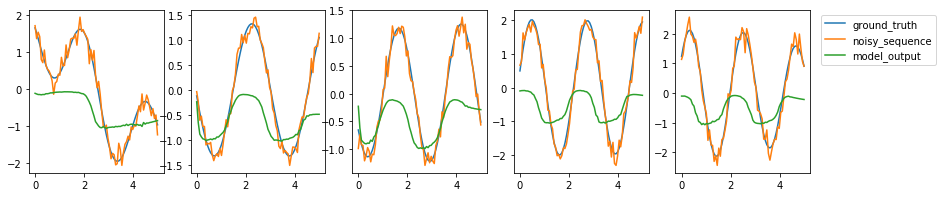

-573.0675% of noise removed.
epoch: 1, train loss:9545.5126953125
epoch: 1, validation loss:9545.5126953125
epoch: 2, train loss:6092.89306640625
epoch: 2, validation loss:6092.89306640625
epoch: 3, train loss:18734.35546875
epoch: 3, validation loss:18734.35546875
epoch: 4, train loss:7232.93115234375
epoch: 4, validation loss:7232.93115234375
epoch: 5, train loss:41183.984375
epoch: 5, validation loss:41183.984375
epoch: 6, train loss:23837.83203125
epoch: 6, validation loss:23837.83203125
epoch: 7, train loss:29885.484375
epoch: 7, validation loss:29885.484375
epoch: 8, train loss:66687.765625
epoch: 8, validation loss:66687.765625
epoch: 9, train loss:11722.1728515625
epoch: 9, validation loss:11722.1728515625
epoch: 10, train loss:95134.3046875
epoch: 10, validation loss:95134.3046875


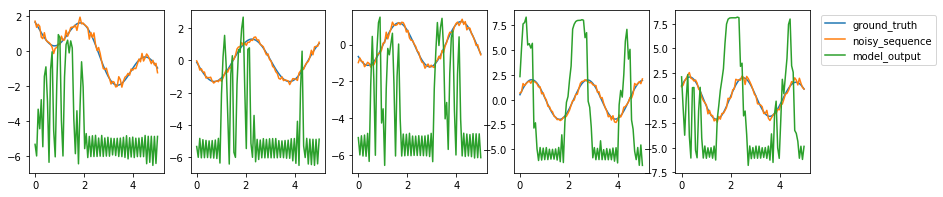

-3543.3342% of noise removed.
epoch: 11, train loss:96317.546875
epoch: 11, validation loss:96317.546875
epoch: 12, train loss:50093.671875
epoch: 12, validation loss:50093.671875
epoch: 13, train loss:105351.46875
epoch: 13, validation loss:105351.46875
epoch: 14, train loss:160370.828125
epoch: 14, validation loss:160370.828125
epoch: 15, train loss:106198.4921875
epoch: 15, validation loss:106198.4921875
epoch: 16, train loss:47198.36328125
epoch: 16, validation loss:47198.36328125
epoch: 17, train loss:107849.09375
epoch: 17, validation loss:107849.09375
epoch: 18, train loss:217995.953125
epoch: 18, validation loss:217995.953125
epoch: 19, train loss:225163.0625
epoch: 19, validation loss:225163.0625
epoch: 20, train loss:90554.140625
epoch: 20, validation loss:90554.140625


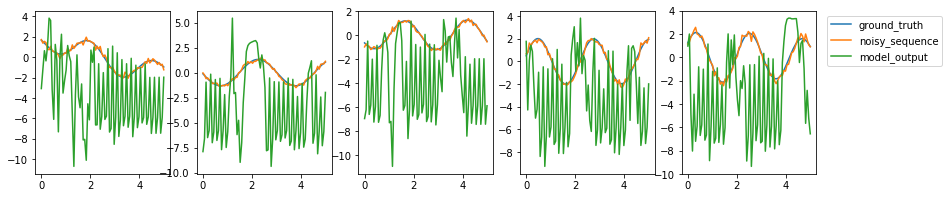

-3104.5677% of noise removed.
epoch: 21, train loss:25076.689453125
epoch: 21, validation loss:25076.689453125
epoch: 22, train loss:96887.421875
epoch: 22, validation loss:96887.421875
epoch: 23, train loss:227763.09375
epoch: 23, validation loss:227763.09375
epoch: 24, train loss:347140.78125
epoch: 24, validation loss:347140.78125
epoch: 25, train loss:239793.046875
epoch: 25, validation loss:239793.046875
epoch: 26, train loss:100831.4765625
epoch: 26, validation loss:100831.4765625
epoch: 27, train loss:46985.21875
epoch: 27, validation loss:46985.21875
epoch: 28, train loss:39913.09765625
epoch: 28, validation loss:39913.09765625
epoch: 29, train loss:58950.61328125
epoch: 29, validation loss:58950.61328125
epoch: 30, train loss:106218.5
epoch: 30, validation loss:106218.5


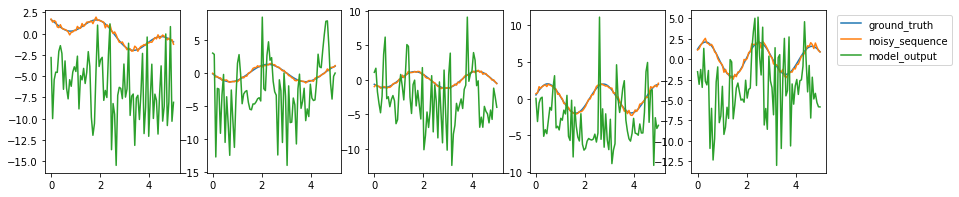

-3400.9918% of noise removed.
epoch: 31, train loss:137654.109375
epoch: 31, validation loss:137654.109375
epoch: 32, train loss:147329.640625
epoch: 32, validation loss:147329.640625
epoch: 33, train loss:124053.1640625
epoch: 33, validation loss:124053.1640625
epoch: 34, train loss:134960.65625
epoch: 34, validation loss:134960.65625
epoch: 35, train loss:172049.328125
epoch: 35, validation loss:172049.328125
epoch: 36, train loss:170736.296875
epoch: 36, validation loss:170736.296875
epoch: 37, train loss:153476.015625
epoch: 37, validation loss:153476.015625
epoch: 38, train loss:106937.3203125
epoch: 38, validation loss:106937.3203125
epoch: 39, train loss:81220.2734375
epoch: 39, validation loss:81220.2734375
epoch: 40, train loss:58823.34375
epoch: 40, validation loss:58823.34375


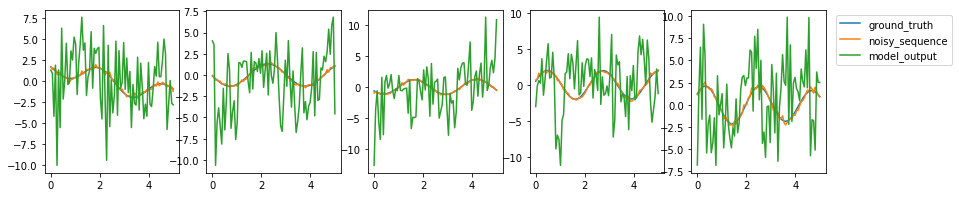

-2335.9198% of noise removed.
epoch: 41, train loss:56759.15234375
epoch: 41, validation loss:56759.15234375
epoch: 42, train loss:76676.84375
epoch: 42, validation loss:76676.84375
epoch: 43, train loss:92767.625
epoch: 43, validation loss:92767.625
epoch: 44, train loss:104571.4375
epoch: 44, validation loss:104571.4375
epoch: 45, train loss:97738.359375
epoch: 45, validation loss:97738.359375
epoch: 46, train loss:79566.515625
epoch: 46, validation loss:79566.515625
epoch: 47, train loss:71291.0703125
epoch: 47, validation loss:71291.0703125
epoch: 48, train loss:79244.6328125
epoch: 48, validation loss:79244.6328125
epoch: 49, train loss:94113.7109375
epoch: 49, validation loss:94113.7109375
epoch: 50, train loss:112763.6796875
epoch: 50, validation loss:112763.6796875


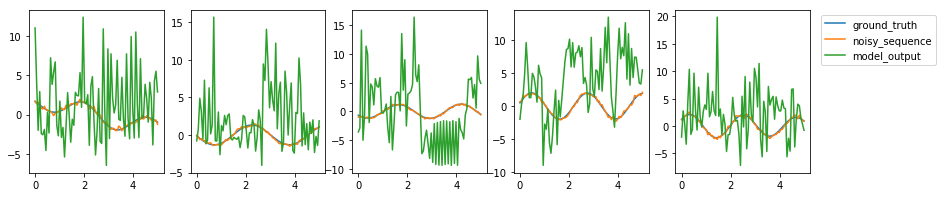

-3214.2166% of noise removed.
epoch: 51, train loss:121097.6015625
epoch: 51, validation loss:121097.6015625
epoch: 52, train loss:123980.65625
epoch: 52, validation loss:123980.65625
epoch: 53, train loss:118385.84375
epoch: 53, validation loss:118385.84375
epoch: 54, train loss:114505.984375
epoch: 54, validation loss:114505.984375
epoch: 55, train loss:108385.9140625
epoch: 55, validation loss:108385.9140625
epoch: 56, train loss:108811.0703125
epoch: 56, validation loss:108811.0703125
epoch: 57, train loss:111931.375
epoch: 57, validation loss:111931.375
epoch: 58, train loss:110124.9296875
epoch: 58, validation loss:110124.9296875
epoch: 59, train loss:127282.3984375
epoch: 59, validation loss:127282.3984375
epoch: 60, train loss:121983.5390625
epoch: 60, validation loss:121983.5390625


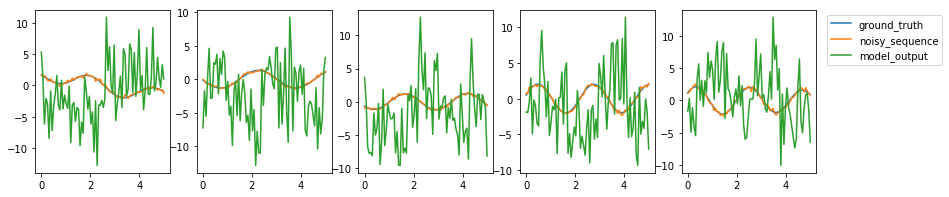

-3554.3037% of noise removed.
epoch: 61, train loss:118368.453125
epoch: 61, validation loss:118368.453125
epoch: 62, train loss:118267.984375
epoch: 62, validation loss:118267.984375
epoch: 63, train loss:106638.828125
epoch: 63, validation loss:106638.828125
epoch: 64, train loss:100090.5859375
epoch: 64, validation loss:100090.5859375
epoch: 65, train loss:89374.859375
epoch: 65, validation loss:89374.859375
epoch: 66, train loss:86385.5859375
epoch: 66, validation loss:86385.5859375
epoch: 67, train loss:78788.453125
epoch: 67, validation loss:78788.453125
epoch: 68, train loss:77175.3359375
epoch: 68, validation loss:77175.3359375
epoch: 69, train loss:75055.9296875
epoch: 69, validation loss:75055.9296875
epoch: 70, train loss:75529.828125
epoch: 70, validation loss:75529.828125


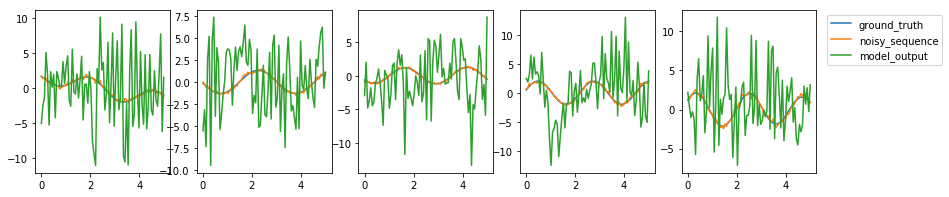

-2617.3668% of noise removed.
epoch: 71, train loss:73571.78125
epoch: 71, validation loss:73571.78125
epoch: 72, train loss:75583.9140625
epoch: 72, validation loss:75583.9140625
epoch: 73, train loss:78228.59375
epoch: 73, validation loss:78228.59375
epoch: 74, train loss:75827.984375
epoch: 74, validation loss:75827.984375
epoch: 75, train loss:83232.859375
epoch: 75, validation loss:83232.859375
epoch: 76, train loss:79683.8671875
epoch: 76, validation loss:79683.8671875
epoch: 77, train loss:80937.8984375
epoch: 77, validation loss:80937.8984375
epoch: 78, train loss:77978.578125
epoch: 78, validation loss:77978.578125
epoch: 79, train loss:79640.375
epoch: 79, validation loss:79640.375
epoch: 80, train loss:77739.6953125
epoch: 80, validation loss:77739.6953125


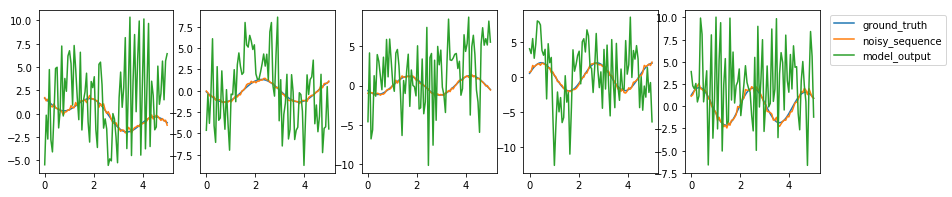

-2823.3793% of noise removed.
epoch: 81, train loss:73436.328125
epoch: 81, validation loss:73436.328125
epoch: 82, train loss:76645.765625
epoch: 82, validation loss:76645.765625
epoch: 83, train loss:78331.6015625
epoch: 83, validation loss:78331.6015625
epoch: 84, train loss:73756.9921875
epoch: 84, validation loss:73756.9921875
epoch: 85, train loss:70703.96875
epoch: 85, validation loss:70703.96875
epoch: 86, train loss:72473.5390625
epoch: 86, validation loss:72473.5390625
epoch: 87, train loss:75670.046875
epoch: 87, validation loss:75670.046875
epoch: 88, train loss:69076.046875
epoch: 88, validation loss:69076.046875
epoch: 89, train loss:70317.71875
epoch: 89, validation loss:70317.71875
epoch: 90, train loss:69669.203125
epoch: 90, validation loss:69669.203125


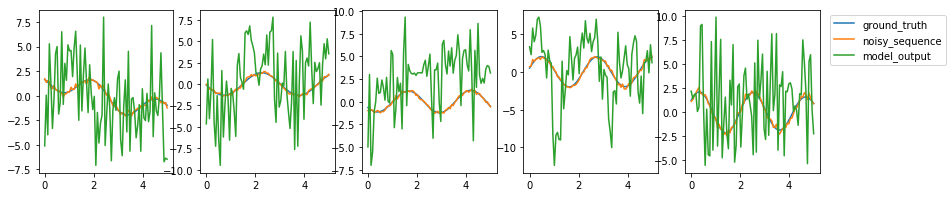

-2625.9224% of noise removed.
epoch: 91, train loss:70181.8671875
epoch: 91, validation loss:70181.8671875
epoch: 92, train loss:67377.21875
epoch: 92, validation loss:67377.21875
epoch: 93, train loss:67303.8125
epoch: 93, validation loss:67303.8125
epoch: 94, train loss:66520.3359375
epoch: 94, validation loss:66520.3359375
epoch: 95, train loss:66943.640625
epoch: 95, validation loss:66943.640625
epoch: 96, train loss:67173.53125
epoch: 96, validation loss:67173.53125
epoch: 97, train loss:67419.734375
epoch: 97, validation loss:67419.734375
epoch: 98, train loss:67724.734375
epoch: 98, validation loss:67724.734375
epoch: 99, train loss:63453.8359375
epoch: 99, validation loss:63453.8359375
epoch: 100, train loss:64580.19140625
epoch: 100, validation loss:64580.19140625


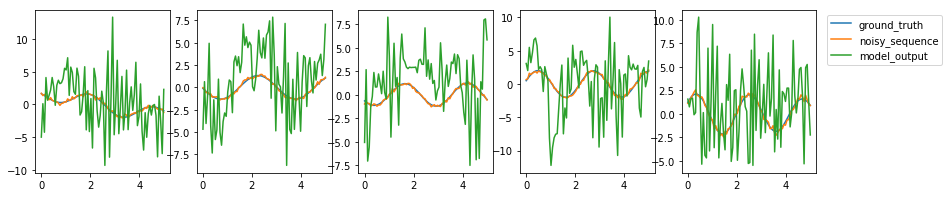

-2529.1885% of noise removed.


In [88]:
batch_size = 10
num_epochs = 101


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)

## Hyperparameter Optimization
As a preparation for next week's lecture, play with the model's hyperparameters and try to improve the amount of noise removed. List at least three different configurations you have tried and the respective percentage of noise removed. Make sure to always create a new model and that you train and validate on the same data!

| configuration        | Noise removed in percent |
| -------------------- | --------------------------: |
| initial configuration| 32.52%               |

epoch: 0, train loss:5121.880859375
epoch: 0, validation loss:5121.880859375


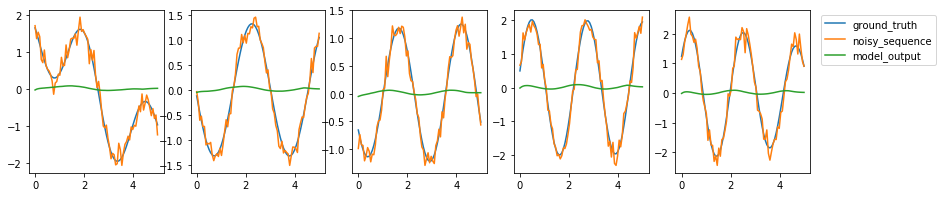

-619.3157% of noise removed.
epoch: 1, train loss:3518.711181640625
epoch: 1, validation loss:3518.711181640625
epoch: 2, train loss:4949.6982421875
epoch: 2, validation loss:4949.6982421875
epoch: 3, train loss:5020.34423828125
epoch: 3, validation loss:5020.34423828125
epoch: 4, train loss:4916.0380859375
epoch: 4, validation loss:4916.0380859375
epoch: 5, train loss:5012.1826171875
epoch: 5, validation loss:5012.1826171875
epoch: 6, train loss:5318.89208984375
epoch: 6, validation loss:5318.89208984375
epoch: 7, train loss:4212.5361328125
epoch: 7, validation loss:4212.5361328125
epoch: 8, train loss:4832.54638671875
epoch: 8, validation loss:4832.54638671875
epoch: 9, train loss:3952.054931640625
epoch: 9, validation loss:3952.054931640625
epoch: 10, train loss:5681.8427734375
epoch: 10, validation loss:5681.8427734375


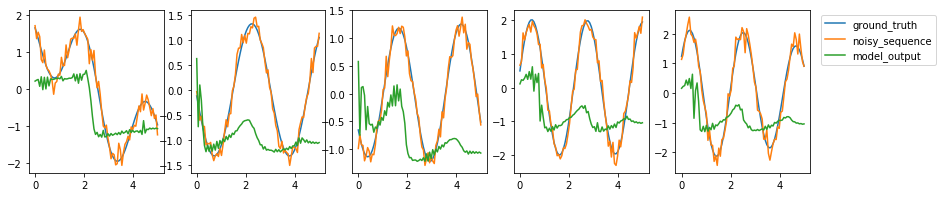

-683.8029% of noise removed.
epoch: 11, train loss:3103.837890625
epoch: 11, validation loss:3103.837890625
epoch: 12, train loss:4358.91015625
epoch: 12, validation loss:4358.91015625
epoch: 13, train loss:4045.35986328125
epoch: 13, validation loss:4045.35986328125
epoch: 14, train loss:3909.073486328125
epoch: 14, validation loss:3909.073486328125
epoch: 15, train loss:3640.344970703125
epoch: 15, validation loss:3640.344970703125
epoch: 16, train loss:4063.72607421875
epoch: 16, validation loss:4063.72607421875
epoch: 17, train loss:3861.29931640625
epoch: 17, validation loss:3861.29931640625
epoch: 18, train loss:3498.936767578125
epoch: 18, validation loss:3498.936767578125
epoch: 19, train loss:3468.30322265625
epoch: 19, validation loss:3468.30322265625
epoch: 20, train loss:3716.76318359375
epoch: 20, validation loss:3716.76318359375


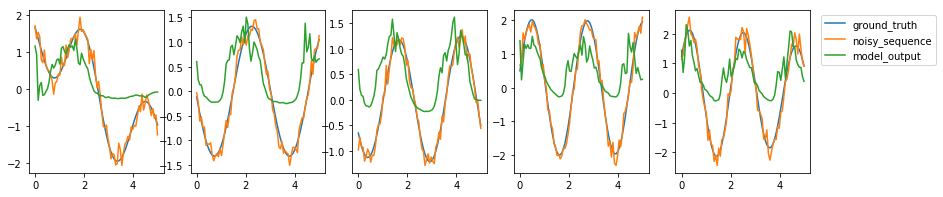

-519.8493% of noise removed.
epoch: 21, train loss:4031.400146484375
epoch: 21, validation loss:4031.400146484375
epoch: 22, train loss:3856.329345703125
epoch: 22, validation loss:3856.329345703125
epoch: 23, train loss:3175.1162109375
epoch: 23, validation loss:3175.1162109375
epoch: 24, train loss:2777.137939453125
epoch: 24, validation loss:2777.137939453125
epoch: 25, train loss:2546.71875
epoch: 25, validation loss:2546.71875
epoch: 26, train loss:2837.917236328125
epoch: 26, validation loss:2837.917236328125
epoch: 27, train loss:2818.44677734375
epoch: 27, validation loss:2818.44677734375
epoch: 28, train loss:2984.665283203125
epoch: 28, validation loss:2984.665283203125
epoch: 29, train loss:3107.234130859375
epoch: 29, validation loss:3107.234130859375
epoch: 30, train loss:2972.582763671875
epoch: 30, validation loss:2972.582763671875


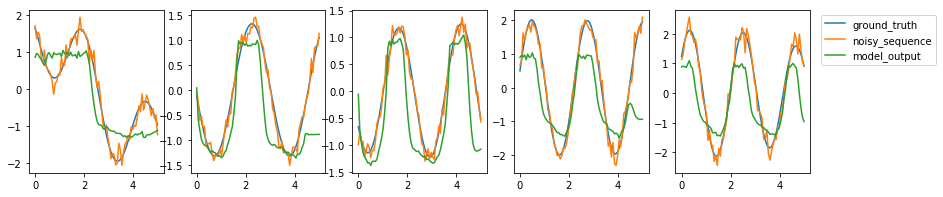

-468.0522% of noise removed.
epoch: 31, train loss:2608.005126953125
epoch: 31, validation loss:2608.005126953125
epoch: 32, train loss:2259.742431640625
epoch: 32, validation loss:2259.742431640625
epoch: 33, train loss:2071.277099609375
epoch: 33, validation loss:2071.277099609375
epoch: 34, train loss:2114.49169921875
epoch: 34, validation loss:2114.49169921875
epoch: 35, train loss:2101.814453125
epoch: 35, validation loss:2101.814453125
epoch: 36, train loss:2067.177978515625
epoch: 36, validation loss:2067.177978515625
epoch: 37, train loss:2401.530517578125
epoch: 37, validation loss:2401.530517578125
epoch: 38, train loss:2410.710693359375
epoch: 38, validation loss:2410.710693359375
epoch: 39, train loss:1963.4222412109375
epoch: 39, validation loss:1963.4222412109375
epoch: 40, train loss:1754.8681640625
epoch: 40, validation loss:1754.8681640625


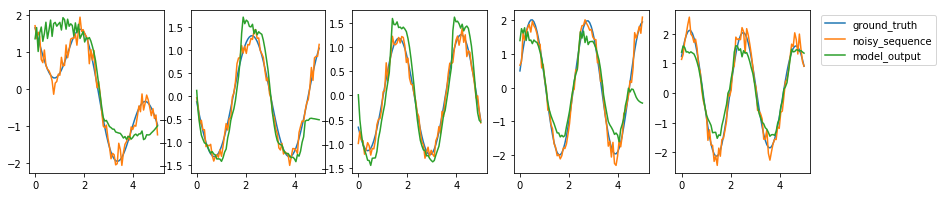

-320.6929% of noise removed.
epoch: 41, train loss:1745.80859375
epoch: 41, validation loss:1745.80859375
epoch: 42, train loss:1811.9844970703125
epoch: 42, validation loss:1811.9844970703125
epoch: 43, train loss:1862.3736572265625
epoch: 43, validation loss:1862.3736572265625
epoch: 44, train loss:1901.780029296875
epoch: 44, validation loss:1901.780029296875
epoch: 45, train loss:1935.9912109375
epoch: 45, validation loss:1935.9912109375
epoch: 46, train loss:1960.247802734375
epoch: 46, validation loss:1960.247802734375
epoch: 47, train loss:1963.4210205078125
epoch: 47, validation loss:1963.4210205078125
epoch: 48, train loss:1941.088134765625
epoch: 48, validation loss:1941.088134765625
epoch: 49, train loss:1906.8223876953125
epoch: 49, validation loss:1906.8223876953125
epoch: 50, train loss:1867.7117919921875
epoch: 50, validation loss:1867.7117919921875


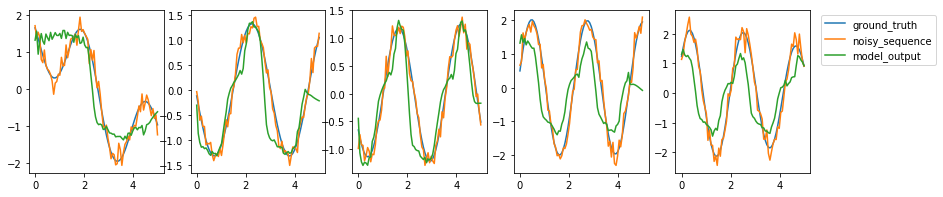

-335.7128% of noise removed.
epoch: 51, train loss:1820.167236328125
epoch: 51, validation loss:1820.167236328125
epoch: 52, train loss:1758.344970703125
epoch: 52, validation loss:1758.344970703125
epoch: 53, train loss:1666.130615234375
epoch: 53, validation loss:1666.130615234375
epoch: 54, train loss:1534.21533203125
epoch: 54, validation loss:1534.21533203125
epoch: 55, train loss:1394.3543701171875
epoch: 55, validation loss:1394.3543701171875
epoch: 56, train loss:1302.6661376953125
epoch: 56, validation loss:1302.6661376953125
epoch: 57, train loss:1285.812255859375
epoch: 57, validation loss:1285.812255859375
epoch: 58, train loss:1315.322265625
epoch: 58, validation loss:1315.322265625
epoch: 59, train loss:1296.830810546875
epoch: 59, validation loss:1296.830810546875
epoch: 60, train loss:1198.9398193359375
epoch: 60, validation loss:1198.9398193359375


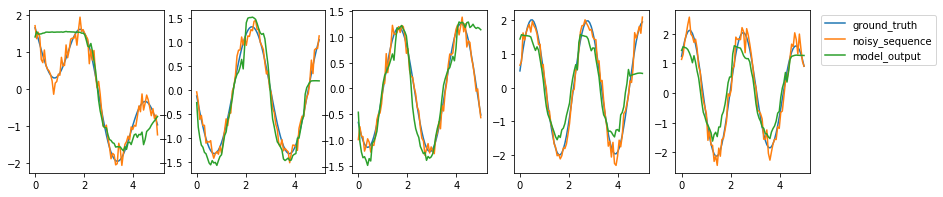

-240.1099% of noise removed.
epoch: 61, train loss:1134.4769287109375
epoch: 61, validation loss:1134.4769287109375
epoch: 62, train loss:1218.4034423828125
epoch: 62, validation loss:1218.4034423828125
epoch: 63, train loss:1332.35498046875
epoch: 63, validation loss:1332.35498046875
epoch: 64, train loss:1280.191162109375
epoch: 64, validation loss:1280.191162109375
epoch: 65, train loss:1145.85791015625
epoch: 65, validation loss:1145.85791015625
epoch: 66, train loss:1134.110107421875
epoch: 66, validation loss:1134.110107421875
epoch: 67, train loss:1223.862060546875
epoch: 67, validation loss:1223.862060546875
epoch: 68, train loss:1314.5738525390625
epoch: 68, validation loss:1314.5738525390625
epoch: 69, train loss:1318.8341064453125
epoch: 69, validation loss:1318.8341064453125
epoch: 70, train loss:1251.158447265625
epoch: 70, validation loss:1251.158447265625


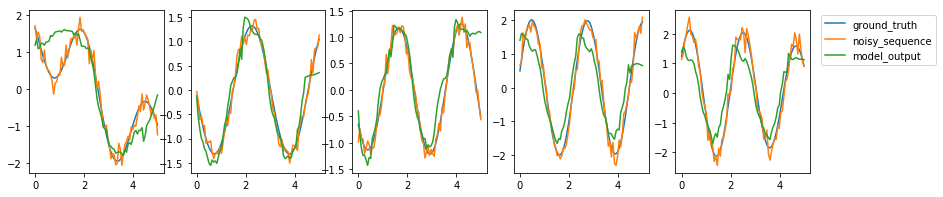

-265.8533% of noise removed.
epoch: 71, train loss:1159.1575927734375
epoch: 71, validation loss:1159.1575927734375
epoch: 72, train loss:1097.1424560546875
epoch: 72, validation loss:1097.1424560546875
epoch: 73, train loss:1084.580810546875
epoch: 73, validation loss:1084.580810546875
epoch: 74, train loss:1119.2967529296875
epoch: 74, validation loss:1119.2967529296875
epoch: 75, train loss:1179.1895751953125
epoch: 75, validation loss:1179.1895751953125
epoch: 76, train loss:1228.530029296875
epoch: 76, validation loss:1228.530029296875
epoch: 77, train loss:1248.1605224609375
epoch: 77, validation loss:1248.1605224609375
epoch: 78, train loss:1225.638427734375
epoch: 78, validation loss:1225.638427734375
epoch: 79, train loss:1173.150390625
epoch: 79, validation loss:1173.150390625
epoch: 80, train loss:1110.2413330078125
epoch: 80, validation loss:1110.2413330078125


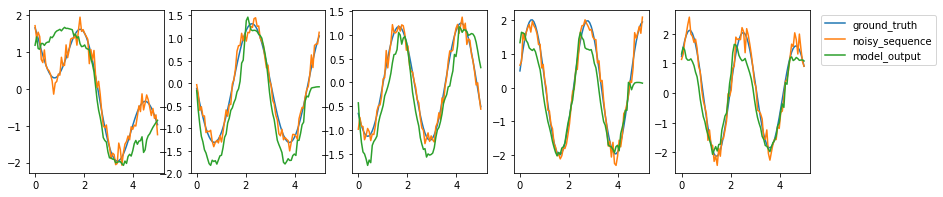

-227.1373% of noise removed.
epoch: 81, train loss:1051.8143310546875
epoch: 81, validation loss:1051.8143310546875
epoch: 82, train loss:1006.1089477539062
epoch: 82, validation loss:1006.1089477539062
epoch: 83, train loss:974.9068603515625
epoch: 83, validation loss:974.9068603515625
epoch: 84, train loss:955.9705200195312
epoch: 84, validation loss:955.9705200195312
epoch: 85, train loss:945.916259765625
epoch: 85, validation loss:945.916259765625
epoch: 86, train loss:943.1245727539062
epoch: 86, validation loss:943.1245727539062
epoch: 87, train loss:943.7686767578125
epoch: 87, validation loss:943.7686767578125
epoch: 88, train loss:945.5325317382812
epoch: 88, validation loss:945.5325317382812
epoch: 89, train loss:947.4188232421875
epoch: 89, validation loss:947.4188232421875
epoch: 90, train loss:948.8988037109375
epoch: 90, validation loss:948.8988037109375


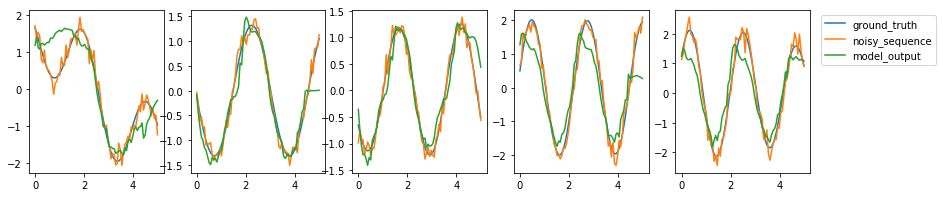

-187.9228% of noise removed.
epoch: 91, train loss:949.7349243164062
epoch: 91, validation loss:949.7349243164062
epoch: 92, train loss:949.91064453125
epoch: 92, validation loss:949.91064453125
epoch: 93, train loss:949.5449829101562
epoch: 93, validation loss:949.5449829101562
epoch: 94, train loss:948.8157348632812
epoch: 94, validation loss:948.8157348632812
epoch: 95, train loss:947.9085693359375
epoch: 95, validation loss:947.9085693359375
epoch: 96, train loss:946.9877319335938
epoch: 96, validation loss:946.9877319335938
epoch: 97, train loss:946.1767578125
epoch: 97, validation loss:946.1767578125
epoch: 98, train loss:945.552734375
epoch: 98, validation loss:945.552734375
epoch: 99, train loss:945.1458740234375
epoch: 99, validation loss:945.1458740234375
epoch: 100, train loss:944.9417114257812
epoch: 100, validation loss:944.9417114257812


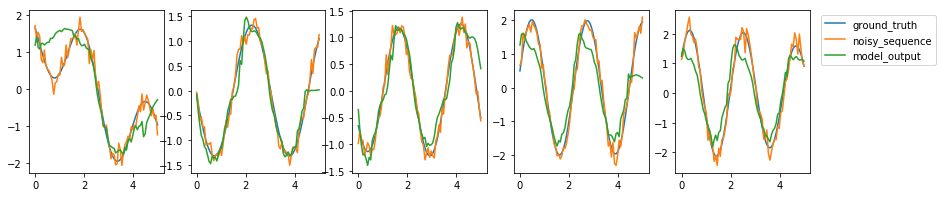

-186.8802% of noise removed.


In [90]:
# learning rate decreased
batch_size = 10
num_epochs = 101
learning_rate = 0.001


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, num_epochs, batch_size)


epoch: 0, train loss:5360.662109375
epoch: 0, validation loss:5360.662109375


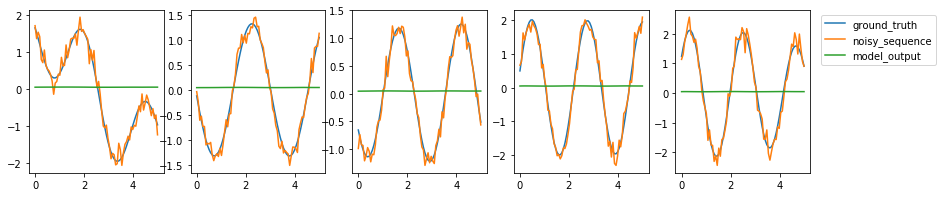

-635.9517% of noise removed.
epoch: 1, train loss:5320.77685546875
epoch: 1, validation loss:5320.77685546875
epoch: 2, train loss:5209.02099609375
epoch: 2, validation loss:5209.02099609375
epoch: 3, train loss:4849.89453125
epoch: 3, validation loss:4849.89453125
epoch: 4, train loss:3453.278076171875
epoch: 4, validation loss:3453.278076171875
epoch: 5, train loss:6117.76123046875
epoch: 5, validation loss:6117.76123046875
epoch: 6, train loss:2267.9775390625
epoch: 6, validation loss:2267.9775390625
epoch: 7, train loss:3452.023193359375
epoch: 7, validation loss:3452.023193359375
epoch: 8, train loss:4099.869140625
epoch: 8, validation loss:4099.869140625
epoch: 9, train loss:4302.810546875
epoch: 9, validation loss:4302.810546875
epoch: 10, train loss:4303.74169921875
epoch: 10, validation loss:4303.74169921875


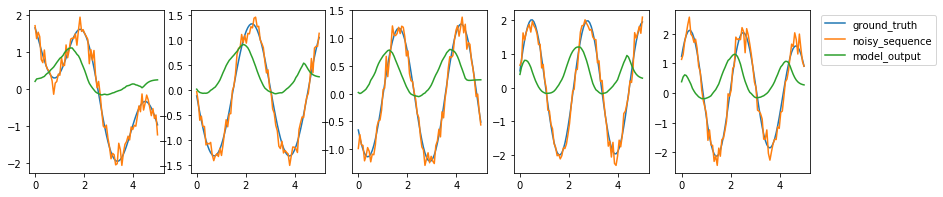

-556.8059% of noise removed.
epoch: 11, train loss:4603.8212890625
epoch: 11, validation loss:4603.8212890625
epoch: 12, train loss:6539.24169921875
epoch: 12, validation loss:6539.24169921875
epoch: 13, train loss:6344.93359375
epoch: 13, validation loss:6344.93359375
epoch: 14, train loss:5059.67041015625
epoch: 14, validation loss:5059.67041015625
epoch: 15, train loss:4848.6337890625
epoch: 15, validation loss:4848.6337890625
epoch: 16, train loss:4948.73828125
epoch: 16, validation loss:4948.73828125
epoch: 17, train loss:5045.54345703125
epoch: 17, validation loss:5045.54345703125
epoch: 18, train loss:5104.37841796875
epoch: 18, validation loss:5104.37841796875
epoch: 19, train loss:5136.72802734375
epoch: 19, validation loss:5136.72802734375
epoch: 20, train loss:5152.9765625
epoch: 20, validation loss:5152.9765625


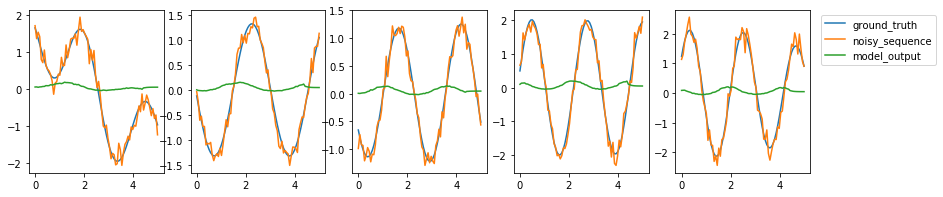

-621.7837% of noise removed.
epoch: 21, train loss:5159.0888671875
epoch: 21, validation loss:5159.0888671875
epoch: 22, train loss:5158.25732421875
epoch: 22, validation loss:5158.25732421875
epoch: 23, train loss:5152.12451171875
epoch: 23, validation loss:5152.12451171875
epoch: 24, train loss:5141.42333984375
epoch: 24, validation loss:5141.42333984375
epoch: 25, train loss:5126.31640625
epoch: 25, validation loss:5126.31640625
epoch: 26, train loss:5106.6015625
epoch: 26, validation loss:5106.6015625
epoch: 27, train loss:5081.87060546875
epoch: 27, validation loss:5081.87060546875
epoch: 28, train loss:5051.66015625
epoch: 28, validation loss:5051.66015625
epoch: 29, train loss:5015.580078125
epoch: 29, validation loss:5015.580078125
epoch: 30, train loss:4973.47216796875
epoch: 30, validation loss:4973.47216796875


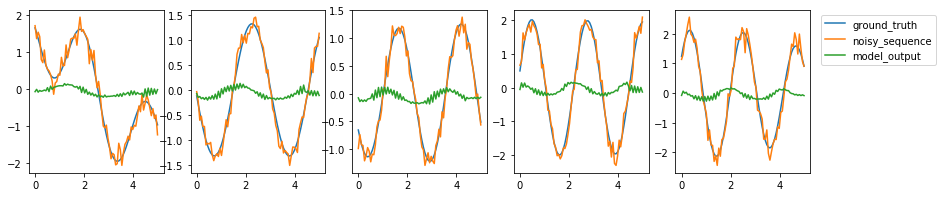

-607.9964% of noise removed.
epoch: 31, train loss:4925.68408203125
epoch: 31, validation loss:4925.68408203125
epoch: 32, train loss:4873.7099609375
epoch: 32, validation loss:4873.7099609375
epoch: 33, train loss:4821.126953125
epoch: 33, validation loss:4821.126953125
epoch: 34, train loss:4773.814453125
epoch: 34, validation loss:4773.814453125
epoch: 35, train loss:4741.6220703125
epoch: 35, validation loss:4741.6220703125
epoch: 36, train loss:4725.47900390625
epoch: 36, validation loss:4725.47900390625
epoch: 37, train loss:4654.712890625
epoch: 37, validation loss:4654.712890625
epoch: 38, train loss:4458.59033203125
epoch: 38, validation loss:4458.59033203125
epoch: 39, train loss:3998.29052734375
epoch: 39, validation loss:3998.29052734375
epoch: 40, train loss:3334.258056640625
epoch: 40, validation loss:3334.258056640625


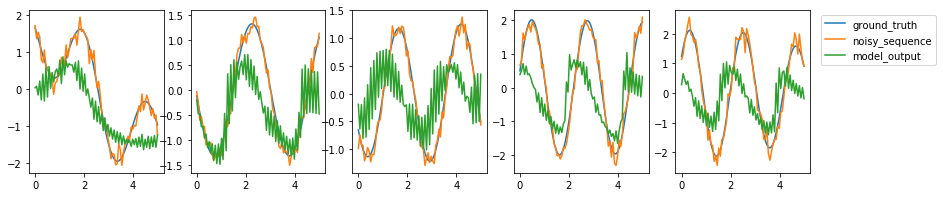

-487.2535% of noise removed.
epoch: 41, train loss:5128.45654296875
epoch: 41, validation loss:5128.45654296875
epoch: 42, train loss:4960.7529296875
epoch: 42, validation loss:4960.7529296875
epoch: 43, train loss:2814.948486328125
epoch: 43, validation loss:2814.948486328125
epoch: 44, train loss:2283.02490234375
epoch: 44, validation loss:2283.02490234375
epoch: 45, train loss:2454.666259765625
epoch: 45, validation loss:2454.666259765625
epoch: 46, train loss:2836.128662109375
epoch: 46, validation loss:2836.128662109375
epoch: 47, train loss:3325.596435546875
epoch: 47, validation loss:3325.596435546875
epoch: 48, train loss:3820.015625
epoch: 48, validation loss:3820.015625
epoch: 49, train loss:4074.062744140625
epoch: 49, validation loss:4074.062744140625
epoch: 50, train loss:3932.8447265625
epoch: 50, validation loss:3932.8447265625


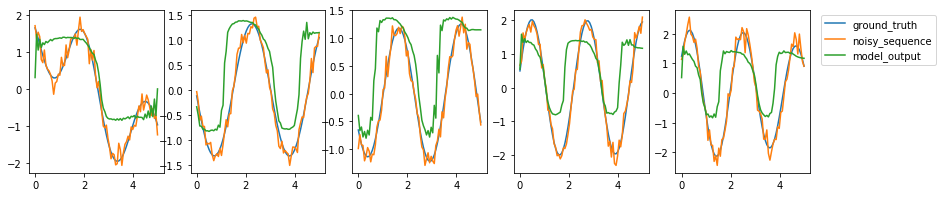

-553.5395% of noise removed.
epoch: 51, train loss:3583.69287109375
epoch: 51, validation loss:3583.69287109375
epoch: 52, train loss:3227.740478515625
epoch: 52, validation loss:3227.740478515625
epoch: 53, train loss:2962.810546875
epoch: 53, validation loss:2962.810546875
epoch: 54, train loss:2799.155517578125
epoch: 54, validation loss:2799.155517578125
epoch: 55, train loss:2712.919677734375
epoch: 55, validation loss:2712.919677734375
epoch: 56, train loss:2699.10546875
epoch: 56, validation loss:2699.10546875
epoch: 57, train loss:2730.6943359375
epoch: 57, validation loss:2730.6943359375
epoch: 58, train loss:2783.412353515625
epoch: 58, validation loss:2783.412353515625
epoch: 59, train loss:2844.13134765625
epoch: 59, validation loss:2844.13134765625
epoch: 60, train loss:2912.13623046875
epoch: 60, validation loss:2912.13623046875


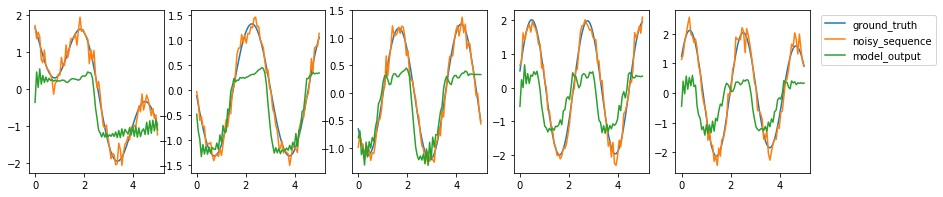

-434.5206% of noise removed.
epoch: 61, train loss:2976.825927734375
epoch: 61, validation loss:2976.825927734375
epoch: 62, train loss:3061.4443359375
epoch: 62, validation loss:3061.4443359375
epoch: 63, train loss:3148.539794921875
epoch: 63, validation loss:3148.539794921875
epoch: 64, train loss:3244.409912109375
epoch: 64, validation loss:3244.409912109375
epoch: 65, train loss:3350.7841796875
epoch: 65, validation loss:3350.7841796875
epoch: 66, train loss:3396.66162109375
epoch: 66, validation loss:3396.66162109375
epoch: 67, train loss:3517.93798828125
epoch: 67, validation loss:3517.93798828125
epoch: 68, train loss:3578.58837890625
epoch: 68, validation loss:3578.58837890625
epoch: 69, train loss:3594.64306640625
epoch: 69, validation loss:3594.64306640625
epoch: 70, train loss:3559.539794921875
epoch: 70, validation loss:3559.539794921875


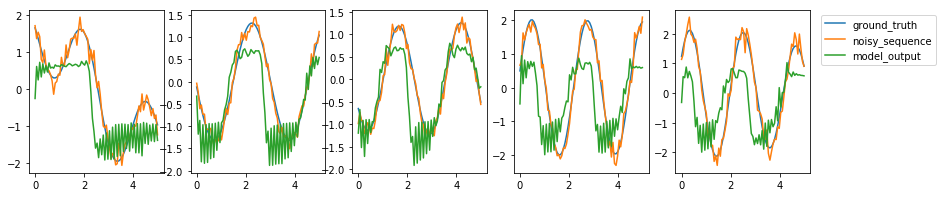

-510.1219% of noise removed.
epoch: 71, train loss:3510.7646484375
epoch: 71, validation loss:3510.7646484375
epoch: 72, train loss:3421.8984375
epoch: 72, validation loss:3421.8984375
epoch: 73, train loss:3297.799560546875
epoch: 73, validation loss:3297.799560546875
epoch: 74, train loss:3196.74365234375
epoch: 74, validation loss:3196.74365234375
epoch: 75, train loss:3101.77734375
epoch: 75, validation loss:3101.77734375
epoch: 76, train loss:3021.814208984375
epoch: 76, validation loss:3021.814208984375
epoch: 77, train loss:2955.108642578125
epoch: 77, validation loss:2955.108642578125
epoch: 78, train loss:2894.35693359375
epoch: 78, validation loss:2894.35693359375
epoch: 79, train loss:2882.64453125
epoch: 79, validation loss:2882.64453125
epoch: 80, train loss:2907.517822265625
epoch: 80, validation loss:2907.517822265625


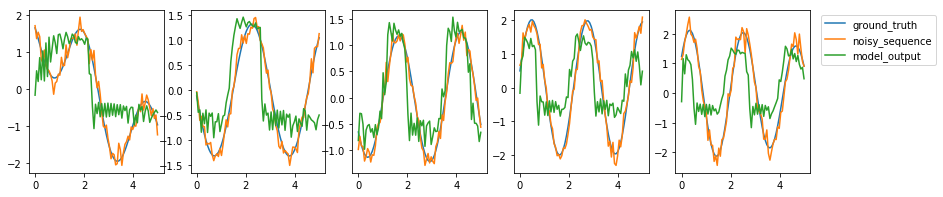

-446.5684% of noise removed.
epoch: 81, train loss:2941.15576171875
epoch: 81, validation loss:2941.15576171875
epoch: 82, train loss:2917.49658203125
epoch: 82, validation loss:2917.49658203125
epoch: 83, train loss:2944.02783203125
epoch: 83, validation loss:2944.02783203125
epoch: 84, train loss:2926.085205078125
epoch: 84, validation loss:2926.085205078125
epoch: 85, train loss:2944.709228515625
epoch: 85, validation loss:2944.709228515625
epoch: 86, train loss:2890.078369140625
epoch: 86, validation loss:2890.078369140625
epoch: 87, train loss:2887.21142578125
epoch: 87, validation loss:2887.21142578125
epoch: 88, train loss:2866.931396484375
epoch: 88, validation loss:2866.931396484375
epoch: 89, train loss:2846.364013671875
epoch: 89, validation loss:2846.364013671875
epoch: 90, train loss:2825.978759765625
epoch: 90, validation loss:2825.978759765625


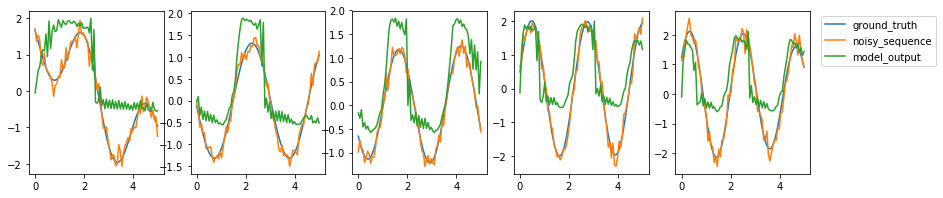

-440.5431% of noise removed.
epoch: 91, train loss:2816.02294921875
epoch: 91, validation loss:2816.02294921875
epoch: 92, train loss:2802.5927734375
epoch: 92, validation loss:2802.5927734375
epoch: 93, train loss:2775.000732421875
epoch: 93, validation loss:2775.000732421875
epoch: 94, train loss:2751.395751953125
epoch: 94, validation loss:2751.395751953125
epoch: 95, train loss:2755.38671875
epoch: 95, validation loss:2755.38671875
epoch: 96, train loss:2766.791259765625
epoch: 96, validation loss:2766.791259765625
epoch: 97, train loss:2785.580078125
epoch: 97, validation loss:2785.580078125
epoch: 98, train loss:2834.61669921875
epoch: 98, validation loss:2834.61669921875
epoch: 99, train loss:2887.040771484375
epoch: 99, validation loss:2887.040771484375
epoch: 100, train loss:2846.00048828125
epoch: 100, validation loss:2846.00048828125


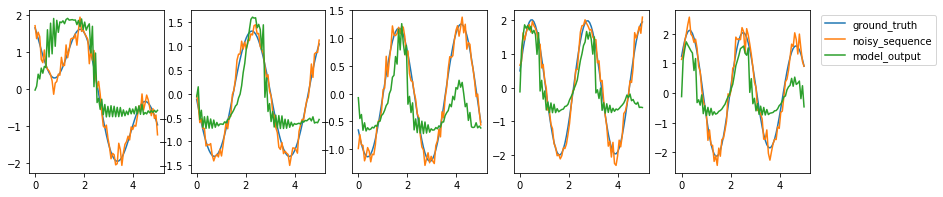

-453.0265% of noise removed.
epoch: 101, train loss:2803.861083984375
epoch: 101, validation loss:2803.861083984375
epoch: 102, train loss:2726.950927734375
epoch: 102, validation loss:2726.950927734375
epoch: 103, train loss:2659.925048828125
epoch: 103, validation loss:2659.925048828125
epoch: 104, train loss:2596.559326171875
epoch: 104, validation loss:2596.559326171875
epoch: 105, train loss:2542.091796875
epoch: 105, validation loss:2542.091796875
epoch: 106, train loss:2497.3642578125
epoch: 106, validation loss:2497.3642578125
epoch: 107, train loss:2460.43701171875
epoch: 107, validation loss:2460.43701171875
epoch: 108, train loss:2426.063720703125
epoch: 108, validation loss:2426.063720703125
epoch: 109, train loss:2398.8115234375
epoch: 109, validation loss:2398.8115234375
epoch: 110, train loss:2373.068359375
epoch: 110, validation loss:2373.068359375


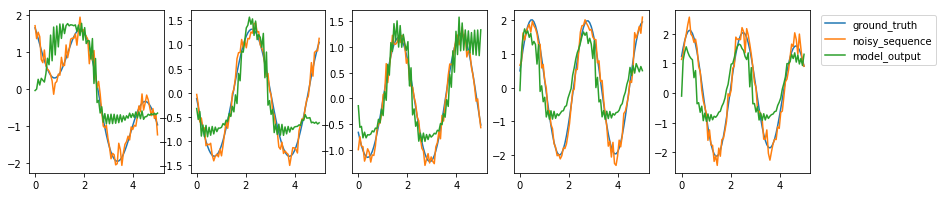

-397.2023% of noise removed.
epoch: 111, train loss:2349.0029296875
epoch: 111, validation loss:2349.0029296875
epoch: 112, train loss:2325.938720703125
epoch: 112, validation loss:2325.938720703125
epoch: 113, train loss:2301.830322265625
epoch: 113, validation loss:2301.830322265625
epoch: 114, train loss:2280.41796875
epoch: 114, validation loss:2280.41796875
epoch: 115, train loss:2264.065673828125
epoch: 115, validation loss:2264.065673828125
epoch: 116, train loss:2248.89306640625
epoch: 116, validation loss:2248.89306640625
epoch: 117, train loss:2227.246826171875
epoch: 117, validation loss:2227.246826171875
epoch: 118, train loss:2203.68701171875
epoch: 118, validation loss:2203.68701171875
epoch: 119, train loss:2175.808837890625
epoch: 119, validation loss:2175.808837890625
epoch: 120, train loss:2160.756591796875
epoch: 120, validation loss:2160.756591796875


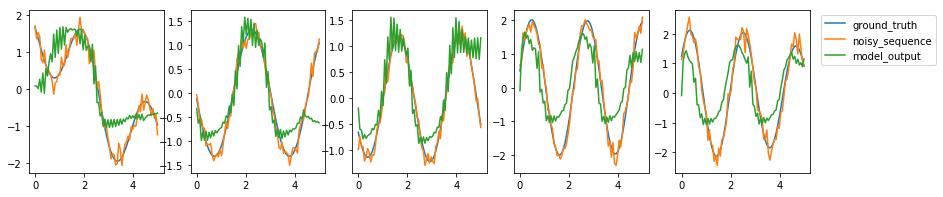

-378.1039% of noise removed.
epoch: 121, train loss:2143.930908203125
epoch: 121, validation loss:2143.930908203125
epoch: 122, train loss:2125.2958984375
epoch: 122, validation loss:2125.2958984375
epoch: 123, train loss:2106.619384765625
epoch: 123, validation loss:2106.619384765625
epoch: 124, train loss:2088.87548828125
epoch: 124, validation loss:2088.87548828125
epoch: 125, train loss:2071.819091796875
epoch: 125, validation loss:2071.819091796875
epoch: 126, train loss:2056.861572265625
epoch: 126, validation loss:2056.861572265625
epoch: 127, train loss:2041.2884521484375
epoch: 127, validation loss:2041.2884521484375
epoch: 128, train loss:2029.774658203125
epoch: 128, validation loss:2029.774658203125
epoch: 129, train loss:2025.50927734375
epoch: 129, validation loss:2025.50927734375
epoch: 130, train loss:2019.310302734375
epoch: 130, validation loss:2019.310302734375


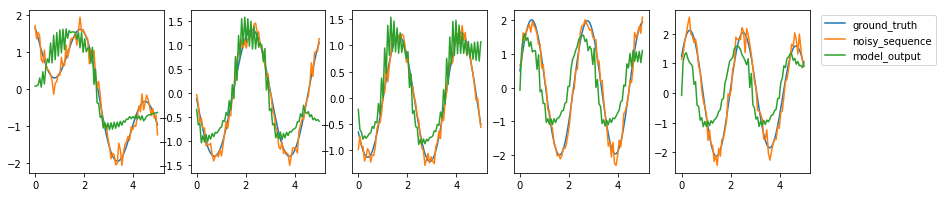

-361.8906% of noise removed.
epoch: 131, train loss:2013.5025634765625
epoch: 131, validation loss:2013.5025634765625
epoch: 132, train loss:2008.688232421875
epoch: 132, validation loss:2008.688232421875
epoch: 133, train loss:2004.9063720703125
epoch: 133, validation loss:2004.9063720703125
epoch: 134, train loss:2002.1080322265625
epoch: 134, validation loss:2002.1080322265625
epoch: 135, train loss:1998.4210205078125
epoch: 135, validation loss:1998.4210205078125
epoch: 136, train loss:1995.81494140625
epoch: 136, validation loss:1995.81494140625
epoch: 137, train loss:1993.4071044921875
epoch: 137, validation loss:1993.4071044921875
epoch: 138, train loss:1991.1861572265625
epoch: 138, validation loss:1991.1861572265625
epoch: 139, train loss:1989.1871337890625
epoch: 139, validation loss:1989.1871337890625
epoch: 140, train loss:1987.432861328125
epoch: 140, validation loss:1987.432861328125


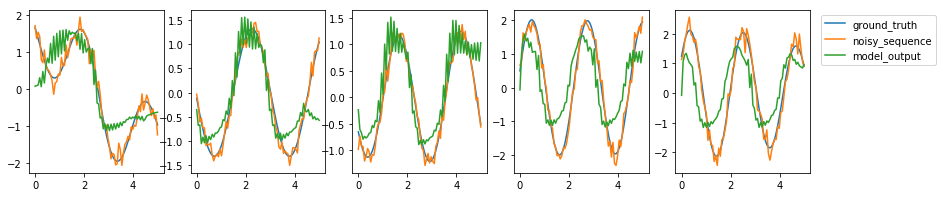

-357.3595% of noise removed.
epoch: 141, train loss:1985.9210205078125
epoch: 141, validation loss:1985.9210205078125
epoch: 142, train loss:1984.654052734375
epoch: 142, validation loss:1984.654052734375
epoch: 143, train loss:1983.64208984375
epoch: 143, validation loss:1983.64208984375
epoch: 144, train loss:1982.843505859375
epoch: 144, validation loss:1982.843505859375
epoch: 145, train loss:1982.1982421875
epoch: 145, validation loss:1982.1982421875
epoch: 146, train loss:1981.7432861328125
epoch: 146, validation loss:1981.7432861328125
epoch: 147, train loss:1981.4996337890625
epoch: 147, validation loss:1981.4996337890625
epoch: 148, train loss:1981.3841552734375
epoch: 148, validation loss:1981.3841552734375
epoch: 149, train loss:1981.3355712890625
epoch: 149, validation loss:1981.3355712890625


In [92]:
# epoch size increased
batch_size = 30
num_epochs = 150
learning_rate = 0.001


model = NoiseRemovalModel(hidden_size=40, shift=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# this should remove ~32% of the noise
train(model, optimizer, scheduler, num_epochs, batch_size)